In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from pathlib import Path
import zipfile
import os
import shutil

In [3]:
# Importing the scans from processed_scans folder, 
fileNames = []

# Create an array of all the file names from the processed_scans folder
for root, dirs, files in os.walk('processed_scans'):
	for file in files:
		fileNames.append(file)

# Importing the labels from the csv file
labels = pd.read_csv('oasis_cross-sectional.csv', dtype=str)

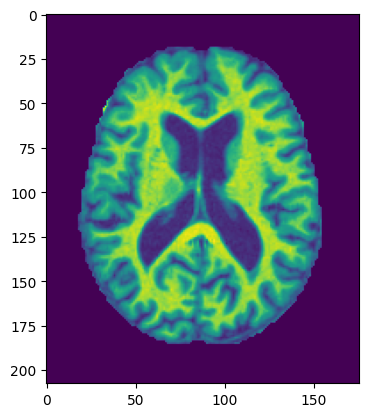

OAS1_0001_MR1.gif
              ID M/F Hand Age Educ SES MMSE CDR  eTIV   nWBV    ASF Delay
0  OAS1_0001_MR1   F    R  74    2   3   29   0  1344  0.743  1.306   NaN


In [4]:
# Display the first image and the label for it
plt.imshow(plt.imread('processed_scans/'+fileNames[0]))
plt.show()
print(fileNames[0])
print(labels[0:1])


In [5]:
image_data = []

for fileName in fileNames:
    img = load_img('processed_scans/'+fileName, target_size=(224, 224))
    img_array = img_to_array(img)
    image_data.append(img_array)

image_data = np.array(image_data)


In [6]:
# Checking to see if there's a corresponding label for each image
checkedLabels = labels[labels['ID'].isin([fileName[:13] for fileName in fileNames])]



In [7]:
def appendToId(id):
	return id + ".png"

# Create a new column in the labels dataframe that contains the file name
checkedLabels['fileNames'] = checkedLabels['ID'].apply(appendToId)

# CDR can be '0.0', '0.5', 'nan', '1.0', '2.0'
# As this is not a scale, but more of a classification, this can be passed as a string, then tokenized
def convertToString(cdr):
	# If it can be converted to a float, then it's a number
	try:
		float(cdr)
		return str(cdr)
	# If it can't be converted to a float, then it's nan
	except ValueError:
		return '0'

# Convert the CDR column to a float (if it's nan, it will be converted to 0)
checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)


C:\Users\mlg\AppData\Local\Temp\ipykernel_7612\1499263606.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['fileNames'] = checkedLabels['ID'].apply(appendToId)
C:\Users\mlg\AppData\Local\Temp\ipykernel_7612\1499263606.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkedLabels['CDR'] = checkedLabels['CDR'].apply(convertToString)


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=360,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    dtype = 'float32'
) # set validation split


In [10]:
args = dict(
	dataframe=checkedLabels,
	directory='C:\Active-Projects\RHUL-FYP\PROJECT\OASIS\processed_scans',  # This is required to have the full path for some reason
	x_col='fileNames',
	y_col='CDR',
	target_size=(224, 224),
	batch_size=32,
	class_mode='categorical',# Binary = it outputs 1 number, not the probability of each class
	shuffle=True,
	seed=42
)

train_ds = train_datagen.flow_from_dataframe(
	**args,
	subset='training',
)

val_ds = train_datagen.flow_from_dataframe(
	**args,
	subset='validation',
)

Found 348 validated image filenames belonging to 5 classes.
Found 87 validated image filenames belonging to 5 classes.


In [11]:
# Printing out the mapping between checkedLabels and train_ds
print(train_ds.class_indices)


{'0': 0, '0.5': 1, '1': 2, '2': 3, 'nan': 4}


c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1873: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


(32, 224, 224, 3)
Empty DataFrame
Columns: [ID, M/F, Hand, Age, Educ, SES, MMSE, CDR, eTIV, nWBV, ASF, Delay, fileNames]
Index: []
[1. 0. 0. 0. 0.]


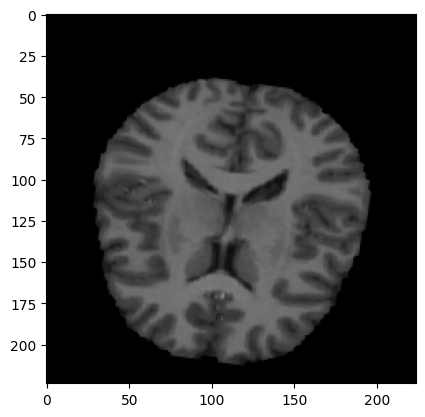

In [12]:
# Show the first image from the training set and the label for it

img, label = train_ds.next()
print(img.shape) 
# print the image label
print(checkedLabels.head(0))
print(label[7])
plt.imshow(img[0])
plt.show()

In [13]:
# Here I'm using the MobileNetV2 model for testing purposes as it is a lightweight model
MobileNetV3Small = keras.applications.MobileNetV3Large(
	input_shape=(224, 224, 3),
	include_top=False, 
	weights='imagenet')


model = Sequential()

# Freezing the layers of the model so that they don't get trained (apart from the last 10)
# This should help the training to not override the feature extraction layers
for layer in MobileNetV3Small.layers[:-10]:
	layer.trainable = False

model.add(MobileNetV3Small)
# Flattening the output of the model to be able to feed it to the dense layer
model.add(Flatten())
# Adding a dense layer with 512 neurons and ReLU activation
model.add(Dense(512, activation='relu'))
# Adding a dropout layer to reduce overfitting
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# Adding the output layer with 4 neurons and softmax activation, this is because we have 4 classes
# The softmax activation will give us the probability of the image belonging to each class
model.add(Dense(4, activation='softmax'))

# The summary of the model is shown, this is to check if the model is being built correctly
model.summary()

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.0001),
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 512)               24084992  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
# Fit the model to the training data
history = model.fit(
	train_ds,
	epochs=2,
	validation_data=val_ds,
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\mlg\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\mlg\AppData\Local\Temp\ipykernel_31300\1591778710.py", line 2, in <module>
      history = model.fit(
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[28,4] labels_size=[28,5]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_114749]